In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from mnist import MNIST
from time import time
import numpy as np

In [2]:
from mnist import MNIST    # pip install python-mnist
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
print("Done.")

Loading dataset....
Done.


In [3]:
def one_hot_encode(y):
    ot=np.zeros((y.size,y.max()+1),dtype=np.float32)
    ot[np.arange(y.size),y]=1
    return ot

In [4]:
y_train=one_hot_encode(y_train)
y_test=one_hot_encode(y_test)

# Import network, layers and functions

In [6]:
from nnet_gpu.network import Sequential
from nnet_gpu.layers import Conv2D,Flatten,Dense,MaxPool,BatchNormalization,Dropout
from nnet_gpu import functions
from nnet_gpu import optimizers
import numpy as np
import cupy as cp

# Make Sequential Model

In [25]:
model=Sequential()
model.add(Conv2D(input_shape=(28,28,1),num_kernels=16,kernel_size=3,stride=(2,2),activation=functions.relu))
model.add(BatchNormalization())
# model.add(MaxPool())
# model.add(Dropout(0.2))
model.add(Conv2D(num_kernels=32,kernel_size=3,stride=(2,2),activation=functions.relu))
model.add(BatchNormalization())
# model.add(MaxPool())
# model.add(Dropout(0.3))
model.add(Conv2D(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(BatchNormalization())
# model.add(GlobalAveragePool())
model.add(Flatten())
model.add(Dense(256,activation=functions.relu))
# model.add(Dropout(0.2))
model.add(Dense(10,activation=functions.softmax))

# View Model Summary

In [26]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
0 Conv2D(Conv2D)          (None, 14, 14, 16)         relu             160
__________________________________________________________________________________________
1 BatchNormalization(Batc (None, 14, 14, 16)         echo             64
__________________________________________________________________________________________
2 Conv2D(Conv2D)          (None, 7, 7, 32)           relu             4640
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 7, 7, 32)           echo             128
__________________________________________________________________________________________
4 Conv2D

# Compile model with optimizer, loss and lr

In [27]:
model.compile(optimizer=optimizers.adam,loss=functions.cross_entropy,learning_rate=0.001)

# Train model

In [12]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [13]:
X_train=cp.asarray(X_train)
y_train=cp.asarray(y_train)
X_test=cp.asarray(X_test)
y_test=cp.asarray(y_test)

In [28]:
model.fit(X_train,y_train,batch_size=256,epochs=1,validation_data=(X_test,y_test))

EPOCH: 1 / 1
Progress:  60000 / 60000  - 0s - 0.090s/sample - loss: 0.0002 - accuracy: 0.9809 - Time: 25.737s
Validation Accuracy: 0.1032 - val_loss: nan - Time: 0.843s


In [29]:
model.validate(validation_data=(X_test,y_test),batch_size=128)
## A wierd bug in Batch normalization gives wrong validation accuracy for single channel

Validation Accuracy: 0.1032 - val_loss: nan - Time: 1.098s


Prediction: [0] 
Correct:    [0]


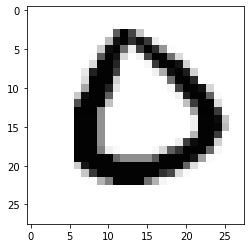

In [20]:
ck=np.random.randint(0,60000-100)
inp,y_inp=X_train[ck:ck+1],y_train[ck:ck+1]
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
print("Prediction:",ans,"\nCorrect:   ",cor)
plt.imshow(inp[0].get().reshape(28,28), cmap='Greys')